<span style="font-size:10pt">AI @ ENSPIMA_2022-2023_v1.0_Jean-Luc CHARLES (Jean-Luc.charles@ensam.eu)_CC BY-SA 4.0</span>

# Problem-based learning
# Training a neural network to diagnose bearing faults - part 1 / 3

### Targeted learning objectives:
Part 1:<br>
- Know how to load files in *Matlab MAT-file* format with *Python*.
- Know how to dimension and fill numpy ndarrays with the data of the `.mat` files
- Know how to display a grid of data plots
- Know how to store the numpy ndarrays in a `.npz` file

Part 2:<br>
- Know how to load a `.npz` into numpy ndarrays
- Know how to process the temporal dataset to get a spectral dataset.
- Know how to display a grid of spectra plots.

Part 3:<br>
- Know how to train/operate a DNN to diagnose bearing faults using a labeled temporal dataset.
- The problem part of the APP: Know how to train/operate a DNN to diagnose bearing faults using a labeled temporal dataset.

<br>
<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:12pt"> 
It is important to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for your main Python projects: <br>
    a PVE makes it possible to control for each project the versions of the Python interpreter and the "sensitive" modules (like tensorflow).<br><br>
    All the notebooks your work on must be loaded into a jupyter-notebook or a jupyter-lab launched in the PVE 
    <b><span style="color: rgb(100, 151, 202);" >pyml-pm</span></b> specially created for the session.<br>
</span></div>

In [1]:
import os, sys
# Delete the (numerous) warning messages from the **tensorflow** module:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

Python    : 3.8.13
tensorflow: 2.8.0 incluant keras 2.8.0
numpy     : 1.23.3


In [2]:
# set the seed of the random generators used by tensorflow:
SEED = 1234

Reminder: The bearing data set was obtained under the experimental conditions
- under normal condition (N)
- with outer race fault (OF)
- with inner race fault (IF)
- with roller fault (OF).

|class label|Fault type|Fault diameter|
|:---------:|:--------:|-------------:|
| 1         | N        | 0            |
| 2         | RF       | 0.18         |
| 3         | RF       | 0.36         |
| 4         | RF       | 0.54         |
| 5         | IF       | 0.36         |
| 6         | IF       | 0.36         |
| 7         | IF       | 0.54         |
| 8         | OF       | 0.18         |
| 9         | OF       | 0.36         |
| 10        | OF       | 0.54         |
 

# 4 $-$ A first try to train the neural network with the temporal dataset

## 4.1 $-$ Load the *CWRU* data and define some useful objects

In [3]:
npzfile = np.load('CWRU_dadaset.npz')
A, B, C = npzfile.values()
full_dataset = (A, B, C)

The dimensions of A are (#health_conditions, #samples, #data_points).

Let's define:
- `H` $\leadsto$ the total number of health conditions
- `S` $\leadsto$ the total number of samples per health contion
- `N` $\leadsto$ the total number of data points per sample
- `L` $\leadsto$ the total number of load cases.

In [4]:
H, S, N = A.shape
L = len(full_dataset)

Let's define the list of the health conditions:

In [5]:
# create the list of the health condition labels:
health_cond = ['N']
for def_type in 'RF', 'IF', 'OF':
    for size in '18', '36', '54':
        health_cond.append(f"{def_type}.{size}")
print(f"list of {len(health_cond)} health conditions:", health_cond)

list of 10 health conditions: ['N', 'RF.18', 'RF.36', 'RF.54', 'IF.18', 'IF.36', 'IF.54', 'OF.18', 'OF.36', 'OF.54']


## 2.1 $-$ Prepare the labeled data for the training

We have two actions to do:
- merge the 200 samples for each of the 10 health conditions and each of the 3 load cases into a single array of 200 $\times$ 10 $\times$ 3 = 6000 samples,
- build the array of the cooreponding 6000 labels.

First we define the arrays with the right shapes:

In [6]:
x_full = np.ndarray((L*H*S, N), dtype='float')  # the array of the samples
y_full = np.ndarray((L*H*S,), dtype='uint8')    # the array of the labels

Let's verify the shape of the arrays:

In [7]:
x_full.shape, y_full.shape

((6000, 1900), (6000,))

Then we fill `x_full` with samples and `y_full` with corresponding labels:

In [8]:
i = 0
for data in (A, B, C):       # browse the 3 load cases
    for h in range(H):       # browse the 10 health conditions -> the labels
        for s in range(S):   # browse the 200 samples
            x_full[i] = data[h, s]
            y_full[i] = h    # the label is given by the health condition loop variable
            i += 1                                                  

To verify, let's plot the sample of rank 10 in `x_full`:

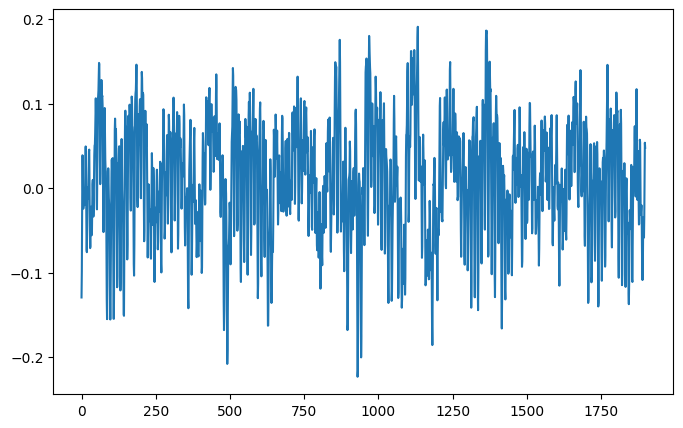

In [9]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

### Normalization of the temporal samples

We normalize the samples of `x_full` by dividing each one by the max of its absolute values.<br>
There are two ways to do this:

a/ Version with an **explicit loop** to browse through all the samples of `x_full`:

In [14]:
for i in range(len(x_full)):
    x_full[i] = x_full[i]/np.abs(x_full[i]).max()

Let's take a look now at the sample of rank 10 in `x_full`:

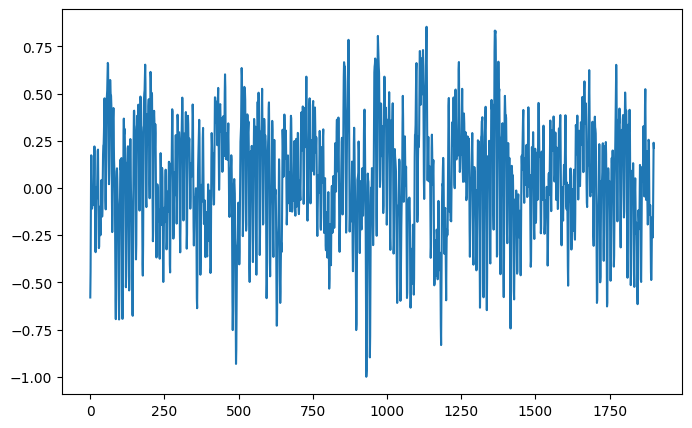

In [15]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

b/ the numpy **vectorized** style (more efficient):

In [16]:
x_full = x_full/np.abs(x_full).max(axis=1, keepdims=True)

Let's take a look now at the sample of rank 10 in `x_full`:

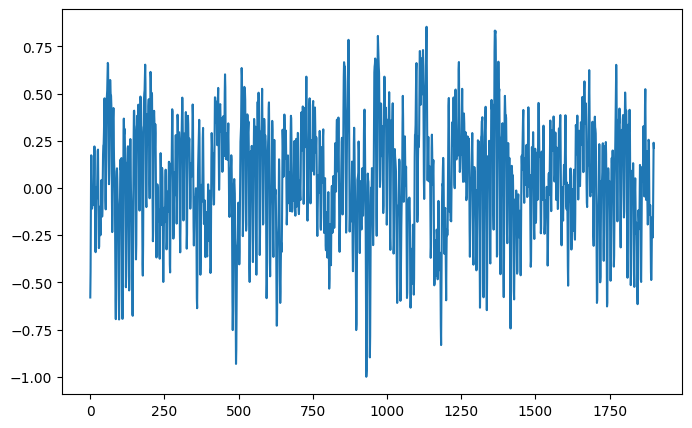

In [17]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

$\leadsto$ the values of `x_full` are now all in the range [-1, 1].

## 4.3 Split the full dataset into train and test datasets

Here we just use the `train_test_split` function from `sklean.model_slection`:

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, lab_train, lab_test = train_test_split(x_full, y_full, 
                                                        stratify=y_full,      # use y_full to evenly distribute all classes 
                                                                              # in the train and test dadasets
                                                        test_size=0.5,        # 50 % test, 50% train 
                                                        random_state=SEED, 
                                                        shuffle=True)         # shuffe randomly the data

## 4.4 Transform labels to *one-hot* format

In [19]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Just a recap the the shapes of the arrays:

In [20]:
x_train.shape, x_test.shape, lab_train.shape, lab_test.shape, y_train.shape, y_test.shape

((3000, 1900), (3000, 1900), (3000,), (3000,), (3000, 10), (3000, 10))

## 4.6 $-$ Build the Deep Neural Network

You will build a dense neural network wit this structure:
    
     Input layer : 1900 inputs
     Hidden layer 'H1' : 1900 neurones, activation fucntion: relu                                                    
     Hidden layer 'H2' : 600  neurones, activation fucntion: relu                          
     Hidden layer 'H3' : 200  neurones, activation fucntion: relu                         
     Hidden layer 'H4' : 100  neurones, activation fucntion: relu
     Output layer      : 10   neurones, activation fucntion: softmax

In [21]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed of the random generators used by tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

# the 5 lines to build the neural network:
model = Sequential()
model.add(Input(shape=(N,), name='Input'))
model.add(Dense(N, activation='relu', name='H1'))
model.add(Dense(600, activation='relu', name='H2'))
model.add(Dense(200, activation='relu', name='H3'))
model.add(Dense(100, activation='relu', name='H4'))
model.add(Dense(H, activation='softmax', name='Output'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 H1 (Dense)                  (None, 1900)              3611900   
                                                                 
 H2 (Dense)                  (None, 600)               1140600   
                                                                 
 H3 (Dense)                  (None, 200)               120200    
                                                                 
 H4 (Dense)                  (None, 100)               20100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 4,893,810
Trainable params: 4,893,810
Non-trainable params: 0
_________________________________________________________________


Let's save the initial values of the network weights if we want to reload later the network to its initial state:

In [23]:
# Check whether the folder 'weights' exists and create it if needed:
if not os.path.isdir("weights"): os.mkdir("weights")

# Save the initial DNN (random) weights:
key = 'CWRU_temporal_init'
model.save_weights(os.path.join('weights', key))

# Display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/CWRU_temporal_init.index
weights/CWRU_temporal_init.data-00000-of-00001


Now we train the neural network with `x_train` & `y_train` as the labeled dataset and `x_test` & `y_test` as the validation labeled dataset to use at the end of each epoch to mesure the network performance.<br>
To avoid any *over-fitting* we use the `EarlyStopping` callback:

Epoch 1/50
47/47 [==============================] - 2s 25ms/step - loss: 1.6960 - accuracy: 0.3597 - val_loss: 1.1148 - val_accuracy: 0.5323
Epoch 2/50
47/47 [==============================] - 1s 22ms/step - loss: 0.6909 - accuracy: 0.7417 - val_loss: 0.7733 - val_accuracy: 0.7180
Epoch 3/50
47/47 [==============================] - 1s 21ms/step - loss: 0.3572 - accuracy: 0.8653 - val_loss: 0.8433 - val_accuracy: 0.7013
Epoch 4/50
47/47 [==============================] - 1s 20ms/step - loss: 0.2310 - accuracy: 0.9150 - val_loss: 0.6970 - val_accuracy: 0.7623
Epoch 5/50
47/47 [==============================] - 1s 20ms/step - loss: 0.1581 - accuracy: 0.9453 - val_loss: 0.8671 - val_accuracy: 0.7293
Epoch 6/50
47/47 [==============================] - 1s 20ms/step - loss: 0.1228 - accuracy: 0.9587 - val_loss: 0.9722 - val_accuracy: 0.7280
Epoch 7/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0996 - accuracy: 0.9640 - val_loss: 0.8080 - val_accuracy: 0.7653
Epoch 8/50
47

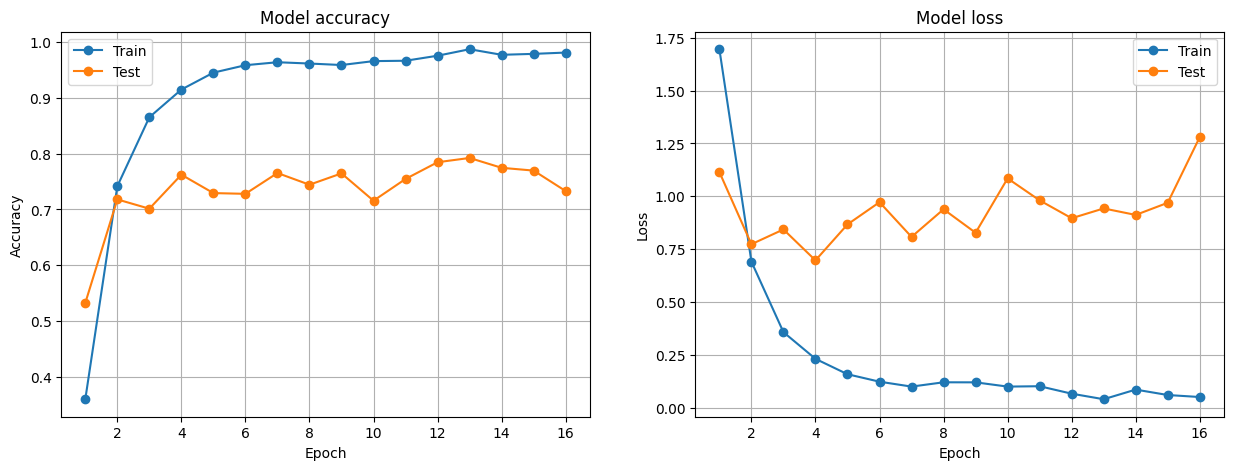

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='loss',   # 
                  patience=3,           #
                  restore_best_weights=True,
                  verbose=1)
]

# in case we execute this cell several times, we can re-initialize 
# the network to its initial state if we want to compare the workouts...
key = 'CWRU_temporal_init'
model.load_weights(os.path.join('weights', key)) 

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

# train the DNN:
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=50, 
                 batch_size=64,                     # number of samples in the batch
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Now we compute the trained network predictions for the test datatset:

In [25]:
results = model.predict(x_test)          # restults is an array of probabilities vectors
inferences = results.argmax(axis=-1)     # extract the highest probablities

And we can plot the **confusion matrix** to  see if the networkd is well trained or not:

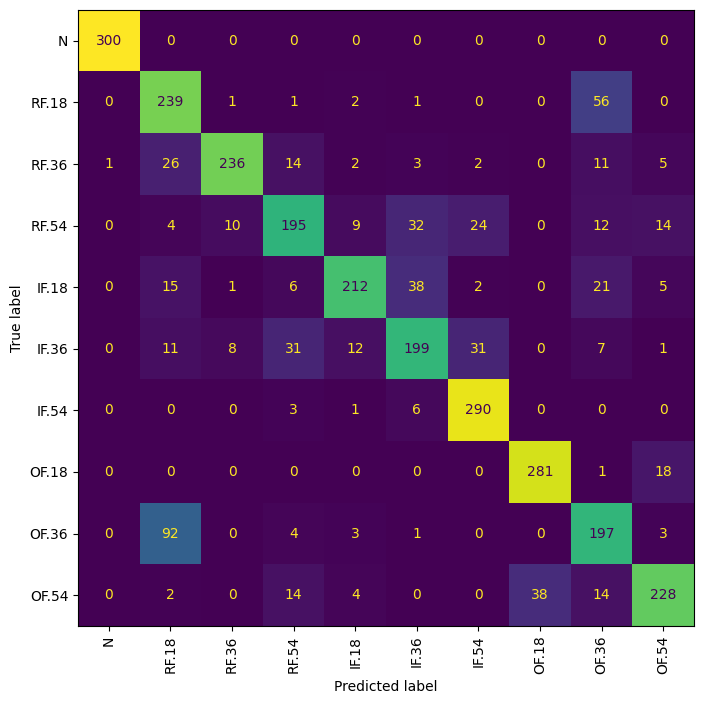

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(8,8))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=health_cond, 
                                        xticks_rotation='vertical',
                                        colorbar=False);

Not all the bearing defaults are recognized with a good score...<br>
$\leadsto$ the next step is to try to train the network with the spectral datasets computed from the temporal samples to see if it's better ?

# 5 $-$ Finally the problem: Train the neural network with the Fourier spectrum of the temporal data set

## 5.1 $-$ Compute the spectral datasets

In [28]:
H, S, N = A.shape
print(f"array A has <{S}> samples of <{N}> data point for each of the <{H}> health conditions ")

array A has <200> samples of <1900> data point for each of the <10> health conditions 


The spectra are computed with [numpy.fft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html)<br>
On the web page, we can see that how to compute the size of the spectrum:

In [29]:
if S % 2 == 0:
    N_spectrum = int(N/2+1)
else:
    N_spectrum = int((N+1)/2)
print(f"size of spectra: {N_spectrum}")    

size of spectra: 951


Now let's define the 3 ndarrays to store the spectra of the 3 temporal data arrays:

In [30]:
A_spectrum = np.ndarray((H, S, N_spectrum), dtype=float)
B_spectrum = np.ndarray((H, S, N_spectrum), dtype=float)
C_spectrum = np.ndarray((H, S, N_spectrum), dtype=float)

and let's compute the spectra with the `np.fft.rfft` function:

In [31]:
for spectrum, dataset in zip((A_spectrum, B_spectrum, C_spectrum), (A, B, C)):
    for h in range(H):
        for s in  range(S):
            rfft = np.abs(np.fft.rfft(dataset[h, s]))   # we take the module of the Fourier spectrum
            spectrum[h, s] = rfft/rfft.max()            # we normalize the spectum to get values in [0,1]

## 5.2 $-$ Prepare the data set for supervised learning

As we saw previously, we can keep only the first 400 spectral points in each sample, so we can define `x_full` and `y_full` with the appropriate shapes:

In [32]:
N_spectrum = 400

x_full = np.ndarray((L*H*S, N_spectrum), dtype='float')
y_full = np.ndarray((L*H*S,), dtype='uint8')

In [33]:
x_full.shape, y_full.shape

((6000, 400), (6000,))

We fill `x_full` and `y_full` appropriately:

In [34]:
i = 0
for spectrum in (A_spectrum, B_spectrum, C_spectrum):
    for h in range(H):
        for s in range(S):
            x_full[i] = spectrum[h, s, :N_spectrum]
            y_full[i] = h
            i += 1                                                  

Have a look on the spectrum of rank 10:

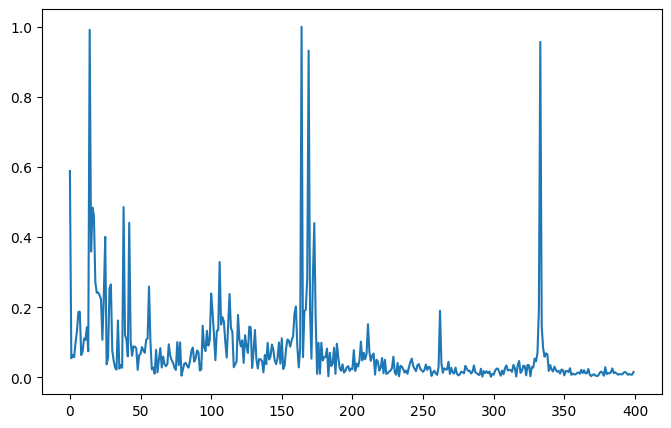

In [35]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10])

## 5.3 Split the full dataset into train and test datasets

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, lab_train, lab_test = train_test_split(x_full, y_full, 
                                                        stratify=y_full, 
                                                        test_size=0.5,        
                                                        random_state=SEED, 
                                                        shuffle=True)         

## 5.4 Transform labels to *one-hot* format

In [37]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Check:

In [38]:
x_train.shape, x_test.shape, lab_train.shape, lab_test.shape, y_train.shape, y_test.shape

((3000, 400), (3000, 400), (3000,), (3000,), (3000, 10), (3000, 10))

## 5.5 $-$ Build the Neural Network

In [39]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed of the random generators used by tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

# the 5 lines to build the neural network:
modelS = Sequential()
modelS.add(Input(shape=(N_spectrum,), name='Input'))
modelS.add(Dense(N_spectrum, activation='relu', name='H1'))
modelS.add(Dense(600, activation='relu', name='H2'))
modelS.add(Dense(200, activation='relu', name='H3'))
modelS.add(Dense(100, activation='relu', name='H4'))
modelS.add(Dense(H, activation='softmax', name='Output'))
modelS.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [40]:
modelS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 H1 (Dense)                  (None, 400)               160400    
                                                                 
 H2 (Dense)                  (None, 600)               240600    
                                                                 
 H3 (Dense)                  (None, 200)               120200    
                                                                 
 H4 (Dense)                  (None, 100)               20100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 542,310
Trainable params: 542,310
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Check whether the folder 'weights' exists and create it if needed:
if not os.path.isdir("weights"): os.mkdir("weights")

# Save the initial DNN (random) weights:
key = 'CWRU_spectral_init'
modelS.save_weights(os.path.join('weights', key))

# Display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/CWRU_spectral_init.index
weights/CWRU_spectral_init.data-00000-of-00001


Epoch 1/200
188/188 [==============================] - 1s 5ms/step - loss: 0.4317 - accuracy: 0.8550 - val_loss: 0.0603 - val_accuracy: 0.9827
Epoch 2/200
188/188 [==============================] - 1s 4ms/step - loss: 0.0354 - accuracy: 0.9920 - val_loss: 0.0149 - val_accuracy: 0.9967
Epoch 3/200
188/188 [==============================] - 1s 4ms/step - loss: 0.0294 - accuracy: 0.9900 - val_loss: 0.0952 - val_accuracy: 0.9717
Epoch 4/200
188/188 [==============================] - 1s 4ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.0254 - val_accuracy: 0.9933
Epoch 5/200
188/188 [==============================] - 1s 4ms/step - loss: 0.0154 - accuracy: 0.9943 - val_loss: 0.0257 - val_accuracy: 0.9927
Epoch 5: early stopping


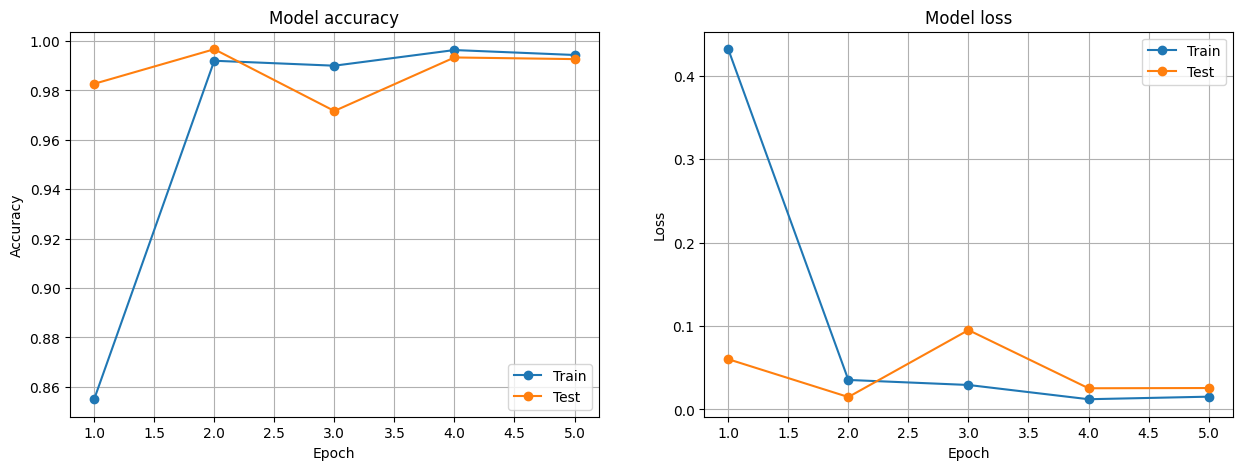

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',   # 
                  patience=3,           #
                  restore_best_weights=True,
                  verbose=1)
]

# in case we execute this cell several times, we can re-initialize 
# the network to its initial state if we want to compare the workouts...
key = 'CWRU_spectral_init'
modelS.load_weights(os.path.join('weights', key)) 

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

# train the DNN:
hist = modelS.fit(x_train, y_train,
                  validation_data=(x_test, y_test), 
                  epochs=200, 
                  batch_size=16,
                  callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

In [43]:
# Check whether the folder 'models' exists and create it if needed:
if not os.path.exists("models"): os.mkdir("models")

# save the trained DNN structure + wieghts:
key = 'CWRU_spectral_init'
modelS.save(os.path.join('models', key) )

# Display the created files:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/CWRU_spectral_init/assets


INFO:tensorflow:Assets written to: models/CWRU_spectral_init/assets


models/CWRU_spectral_init


Now we compute the trained network predictions for the test datatset:

In [44]:
results = modelS.predict(x_test)          # restults is an array of probabilities vectors
inferences = results.argmax(axis=-1)     # extract the highest probablities

And we can plot the **confusion matrix** to  see if the networkd is well trained or not:

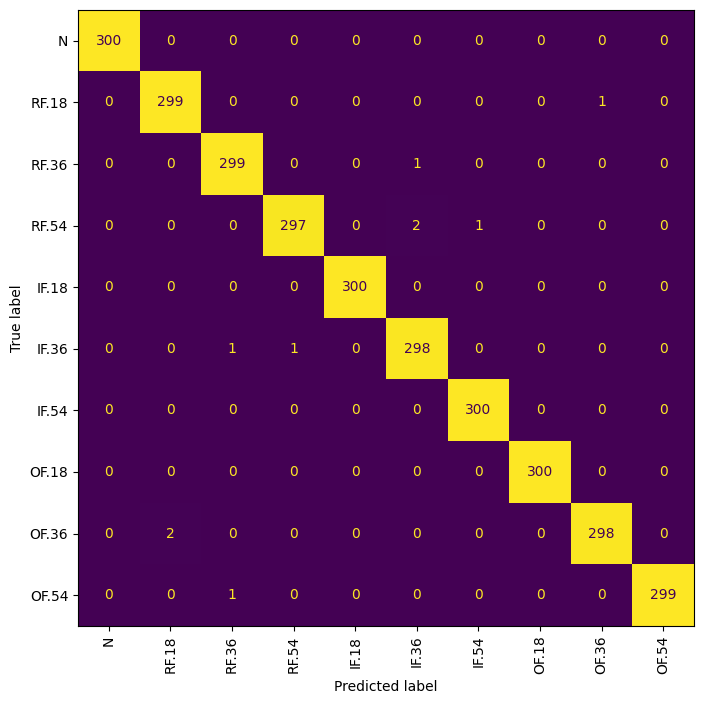

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(8,8))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=health_cond, 
                                        xticks_rotation='vertical',
                                        colorbar=False);